In [ ]:
#En este notebook vamos a probar con el modelo de Random Forest y  GridSearchCV

# Import data

In [13]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv("../data/diamonds_train.csv")

In [3]:
data = data[['carat',
             'cut', 
             'color', 
             'clarity', 
             'depth', 
             'table', 
             'x', 
             'y', 
             'z', 
             'price']]
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Premium,J,VS2,62.4,58.0,6.83,6.79,4.25,4268
1,0.32,Very Good,H,VS2,63.0,57.0,4.35,4.38,2.75,505
2,0.71,Fair,G,VS1,65.5,55.0,5.62,5.53,3.65,2686
3,0.41,Good,D,SI1,63.8,56.0,4.68,4.72,3.00,738
4,1.02,Ideal,G,SI1,60.5,59.0,6.55,6.51,3.95,4882


In [4]:
# Sustituir los ceros en las columnas "x", "y" y "z" por 1
data["x"] = data["x"].replace(0, np.nan)
data["y"] = data["y"].replace(0, np.nan)
data["z"] = data["z"].replace(0, np.nan)

# Calcular la media de cada columna
x_mean = data["x"].mean()
y_mean = data["y"].mean()
z_mean = data["z"].mean()

# Reemplazar NaN por la media de cada columna
data["x"] = data["x"].fillna(x_mean)
data["y"] = data["y"].fillna(y_mean)
data["z"] = data["z"].fillna(z_mean)


In [5]:
# Calcular la mediana de cada columna
depth_median = data["depth"].median()
table_median = data["table"].median()
x_median = data["x"].median()
y_median = data["y"].median()
z_median = data["z"].median()

# Reemplazar los valores atípicos por la mediana de cada columna
data["depth"] = np.where((data["depth"] < 45) | (data["depth"] > 75), depth_median, data["depth"])
data["table"] = np.where((data["table"] < 40) | (data["table"] > 80), table_median, data["table"])
data["x"] = np.where(data["x"] > 30, x_median, data["x"])
data["y"] = np.where(data["y"] > 30, y_median, data["y"])
data["z"] = np.where((data["z"] > 30) | (data["z"] < 2), z_median, data["z"])

In [6]:
# Get list of categorical variables
s = (data.dtypes =="object")
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)


Categorical variables:
['cut', 'color', 'clarity']


In [7]:
# Make copy to avoid changing original data 
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
    
label_data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,3,6,5,62.4,58.0,6.83,6.79,4.25,4268
1,0.32,4,4,5,63.0,57.0,4.35,4.38,2.75,505
2,0.71,0,3,4,65.5,55.0,5.62,5.53,3.65,2686
3,0.41,1,0,2,63.8,56.0,4.68,4.72,3.00,738
4,1.02,2,3,2,60.5,59.0,6.55,6.51,3.95,4882


<Axes: >

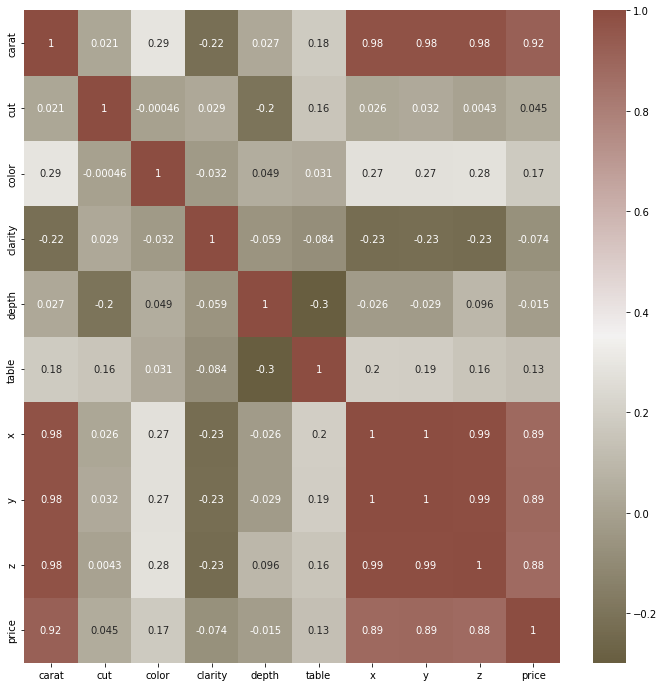

In [8]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [9]:
# Assigning the featurs as X and trarget as y
X= label_data.drop(["price"],axis =1)
y= label_data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=7)

In [10]:
# Definir el modelo
model = RandomForestRegressor()

In [11]:
# Definir la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [14]:
# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


In [15]:
# Ajustar GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [16]:
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [18]:
# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred, squared=False)
print("Error cuadrático medio en el conjunto de prueba:", mse)

Error cuadrático medio en el conjunto de prueba: 570.9491505693272


/Users/sil/miniconda3/envs/jupyter_env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## TEST

In [19]:
data = pd.read_csv("../data/diamonds_test.csv")

In [21]:
data = data[['carat',
             'cut', 
             'color', 
             'clarity', 
             'depth', 
             'table', 
             'x', 
             'y', 
             'z']]
data.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,Very Good,F,SI1,62.7,60.0,5.82,5.89,3.67
1,1.20,Ideal,J,VS1,61.0,57.0,6.81,6.89,4.18
2,1.57,Premium,H,SI1,62.2,61.0,7.38,7.32,4.57
3,0.90,Very Good,F,SI1,63.8,54.0,6.09,6.13,3.90
4,0.50,Very Good,F,VS1,62.9,58.0,5.05,5.09,3.19


In [22]:
# Sustituir los ceros en las columnas "x", "y" y "z" por 1
data["x"] = data["x"].replace(0, np.nan)
data["y"] = data["y"].replace(0, np.nan)
data["z"] = data["z"].replace(0, np.nan)

# Calcular la media de cada columna
x_mean = data["x"].mean()
y_mean = data["y"].mean()
z_mean = data["z"].mean()

# Reemplazar NaN por la media de cada columna
data["x"] = data["x"].fillna(x_mean)
data["y"] = data["y"].fillna(y_mean)
data["z"] = data["z"].fillna(z_mean)


/var/folders/1m/9tdt_k994v175ff72qvvlr7r0000gn/T/ipykernel_96445/740019983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["x"] = data["x"].replace(0, np.nan)
/var/folders/1m/9tdt_k994v175ff72qvvlr7r0000gn/T/ipykernel_96445/740019983.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["y"] = data["y"].replace(0, np.nan)
/var/folders/1m/9tdt_k994v175ff72qvvlr7r0000gn/T/ipykernel_96445/740019983.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [23]:
# Calcular la mediana de cada columna
depth_median = data["depth"].median()
table_median = data["table"].median()
x_median = data["x"].median()
y_median = data["y"].median()
z_median = data["z"].median()

# Reemplazar los valores atípicos por la mediana de cada columna
data["depth"] = np.where((data["depth"] < 45) | (data["depth"] > 75), depth_median, data["depth"])
data["table"] = np.where((data["table"] < 40) | (data["table"] > 80), table_median, data["table"])
data["x"] = np.where(data["x"] > 30, x_median, data["x"])
data["y"] = np.where(data["y"] > 30, y_median, data["y"])
data["z"] = np.where((data["z"] > 30) | (data["z"] < 2), z_median, data["z"])

/var/folders/1m/9tdt_k994v175ff72qvvlr7r0000gn/T/ipykernel_96445/936624210.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["depth"] = np.where((data["depth"] < 45) | (data["depth"] > 75), depth_median, data["depth"])
/var/folders/1m/9tdt_k994v175ff72qvvlr7r0000gn/T/ipykernel_96445/936624210.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["table"] = np.where((data["table"] < 40) | (data["table"] > 80), table_median, data["table"])
/var/folders/1m/9tdt_k994v175ff72qvvlr7r0000gn/T/ipykernel_

In [24]:
# Make copy to avoid changing original data 
label_data = data.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in object_cols:
    label_data[col] = label_encoder.fit_transform(label_data[col])
    
label_data.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.79,4,2,2,62.7,60.0,5.82,5.89,3.67
1,1.20,2,6,4,61.0,57.0,6.81,6.89,4.18
2,1.57,3,4,2,62.2,61.0,7.38,7.32,4.57
3,0.90,4,2,2,63.8,54.0,6.09,6.13,3.90
4,0.50,4,2,4,62.9,58.0,5.05,5.09,3.19


<Axes: >

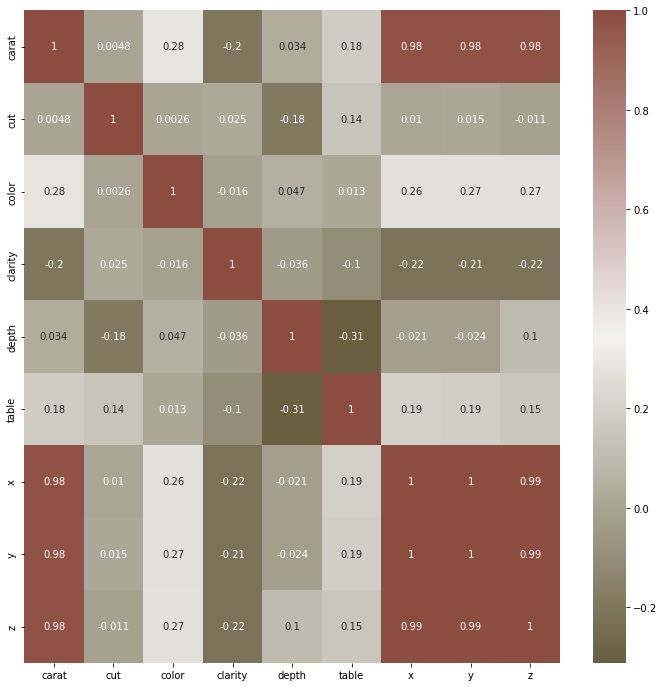

In [25]:
#correlation matrix
cmap = sns.diverging_palette(70,20,s=50, l=40, n=6,as_cmap=True)
corrmat= label_data.corr()
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corrmat,cmap=cmap,annot=True, )

In [26]:
# Definir el modelo
model = RandomForestRegressor()

In [27]:
# Definir la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [28]:
# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')


In [30]:
# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Mejores hiperparámetros:", best_params)

Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 150}


In [37]:
# Evaluar el modelo con los mejores hiperparámetros en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(label_data)


In [40]:
predictions = pd.DataFrame(y_pred, columns=['price'])


In [41]:
predictions['id'] = range(0, len(predictions))
predictions

,price,id
0,3060.088508,0
1,5319.833069,1
2,8374.121690,2
3,4294.417757,3
4,1652.558624,4
...,...,...
13480,1684.142318,13480
13481,2379.867856,13481
13482,3038.125585,13482
13483,2204.016720,13483


In [42]:
predictions = predictions[['id', 'price']]
predictions

,id,price
0,0,3060.088508
1,1,5319.833069
2,2,8374.121690
3,3,4294.417757
4,4,1652.558624
...,...,...
13480,13480,1684.142318
13481,13481,2379.867856
13482,13482,3038.125585
13483,13483,2204.016720


In [44]:
predictions.to_csv('../data/submission/submission_XgBoost_MSR_ultimo.csv', index = False)